In [54]:
import os
import sys
import time
import copy
import random
import warnings
import pickle
import os
import json
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets, transforms, models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from collections import Counter

# Plot settings
# plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Ignore warnings
warnings.filterwarnings("ignore")

# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda:0


In [1]:
# def plot_metric_over_rounds(metric_history):
#     markers = ['x', '^', 's', 'D', 'o', 'P', 'X', '*']
#     linestyles = ['-'] * len(markers)
#     base_markevery = [0, 5, 10, 15, 20]
#     ms = 5
#     grid_color = 'grey'

#     # Unicode symbol mapping
#     unicode_labels = {
#         "mag consistency": "γ",
#         "sim consistency": "ζ",
#         "contribution stability": "η",
#         "beta normalized": "ψ"
#     }

#     for metric_name, client_data in metric_history.items():
#         plt.figure(figsize=(2.84, 2.22))

#         for i, (client_id, values) in enumerate(client_data.items()):
#             marker = markers[i % len(markers)]
#             linestyle = linestyles[i % len(linestyles)]
#             x_vals = list(range(1, len(values) + 1))
#             valid_marks = [x - 1 for x in base_markevery if 1 <= x <= len(values)]

#             plt.plot(
#                 x_vals,
#                 values,
#                 label=f'Client {client_id +1}',
#                 color=f'C{i}',
#                 marker=marker,
#                 markevery=valid_marks,
#                 linestyle=linestyle,
#                 linewidth=1.5,
#                 markersize=ms
#             )

#         # Normalize the metric_name for lookup
#         metric_key = metric_name.strip().lower()
#         y_label = unicode_labels.get(metric_key, metric_name)

#         plt.xlabel("round", fontsize=10, labelpad=2)
#         plt.ylabel(y_label, fontsize=10, labelpad=6)

#         plt.xticks([0, 5, 10, 15, 20], fontsize=9)
#         plt.yticks([0, 0.4, 0.8, 1.2], fontsize=9)
#         plt.xlim(0, 20)
#         plt.ylim(0, 1.2)

#         plt.grid(True, axis='x', color=grid_color)
#         ax = plt.gca()
#         ax.spines['top'].set_visible(False)
#         ax.spines['right'].set_visible(False)
#         ax.spines['left'].set_color(grid_color)
#         ax.spines['bottom'].set_color(grid_color)

#         plt.legend(fontsize=9)
#         # plt.tight_layout(rect=[0.08, 0.05, 0.98, 0.98])
#         plt.tight_layout()
#         plt.savefig(f"({metric_name}).pdf", dpi=1000, bbox_inches='tight',pad_inches=0)
#         plt.show()


In [2]:
# def plot_metric_over_rounds(metric_history):
#     markers = ['x', '^', 's', 'D', 'o', 'P', 'X', '*']
#     linestyles = ['-'] * len(markers)
#     base_markevery = [0, 5, 10, 15, 20]
#     ms = 5
#     grid_color = 'grey'

#     # Unicode symbol mapping
#     unicode_labels = {
#         "mag consistency": "γ",
#         "sim consistency": "ζ",
#         "contribution stability": "η",
#         "beta normalized": "ψ"
#     }

#     for metric_name, client_data in metric_history.items():
#         plt.figure(figsize=(2.84, 2.22))

#         for i, (client_id, values) in enumerate(client_data.items()):
#             marker = markers[i % len(markers)]
#             linestyle = linestyles[i % len(linestyles)]
#             x_vals = list(range(1, len(values) + 1))
#             valid_marks = [x - 1 for x in base_markevery if 1 <= x <= len(values)]

#             plt.plot(
#                 x_vals,
#                 values,
#                 label=f'Client {client_id +1}',
#                 color=f'C{i}',
#                 marker=marker,
#                 markevery=valid_marks,
#                 linestyle=linestyle,
#                 linewidth=1.5,
#                 markersize=ms
#             )

#         # Normalize the metric_name for lookup
#         metric_key = metric_name.strip().lower()
#         y_label = unicode_labels.get(metric_key, metric_name)

#         plt.xlabel("round", fontsize=10, labelpad=2)
#         plt.ylabel(y_label, fontsize=10, labelpad=6)

#         plt.xticks([0, 5, 10, 15, 20], fontsize=9)
#         # plt.yticks([0, 0.4, 0.8, 1.2], fontsize=9)
#         plt.xlim(0, 20)
#         plt.yticks([0, 0.1, 0.2, 0.3], fontsize=9)
#         plt.ylim(0, 0.3)

#         plt.grid(True, axis='x', color=grid_color)
#         ax = plt.gca()
#         ax.spines['top'].set_visible(False)
#         ax.spines['right'].set_visible(False)
#         ax.spines['left'].set_color(grid_color)
#         ax.spines['bottom'].set_color(grid_color)

#         plt.legend(fontsize=9)
#         # plt.tight_layout(rect=[0.08, 0.05, 0.98, 0.98])
#         plt.tight_layout()
#         plt.savefig(f"({metric_name}).pdf", dpi=1000, bbox_inches='tight',pad_inches=0)
#         plt.show()


In [3]:
# # Use the same folder_name as above
# folder_name = f"RAF"

# # Load metric_history
# with open(os.path.join(folder_name, 'metric_history.pkl'), 'rb') as f:
#     metric_history = pickle.load(f)



In [4]:
# metric_history

In [5]:
# # Original mapping from metric name → symbol
# key_to_symbol = {
#     "mag_consistency": "γ",
#     "sim_consistency": "ζ",
#     "contribution_stability": "η",
#     "beta_normalized": "β"
# }

# # Apply renaming
# renamed_metric_history = {}

# for key, value in metric_history.items():
#     new_key = key_to_symbol.get(key.lower(), key)  # Fallback to original if no match
#     renamed_metric_history[new_key] = value


In [6]:
# plot_metric_over_rounds(renamed_metric_history )

In [7]:
# import matplotlib.pyplot as plt
# import os
# import pickle

# def plot_trust_scores(trust_score_history):
#     markers = ['x', '^', 's', 'D', 'o', 'P', 'X', '*']
#     linestyles = ['-'] * len(markers)
#     base_markevery = [0, 5, 10, 15, 20]
#     ms = 5
#     grid_color = 'grey'

#     plt.figure(figsize=(2.84, 2.22))

#     for i, (client_id, scores) in enumerate(trust_score_history.items()):
#         marker = markers[i % len(markers)]
#         linestyle = linestyles[i % len(linestyles)]
#         x_vals = list(range(1, len(scores) + 1))
#         valid_marks = [x - 1 for x in base_markevery if 1 <= x <= len(scores)]

#         plt.plot(
#             x_vals,
#             scores,
#             label=f'Client {client_id}',
#             color=f'C{i}',
#             marker=marker,
#             markevery=valid_marks,
#             linestyle=linestyle,
#             linewidth=1.5,
#             markersize=ms
#         )

#     plt.xlabel("round", fontsize=10, labelpad=2)
#     plt.ylabel("τ", fontsize=10, labelpad=6)  # Using Greek letter tau for trust

#     plt.xticks([0, 5, 10, 15, 20], fontsize=9)
#     plt.yticks([0, 0.4, 0.8, 1.2], fontsize=9)
#     plt.xlim(0, 20)
#     plt.ylim(0, 1.2)

#     plt.grid(True, axis='x', color=grid_color)
#     ax = plt.gca()
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['left'].set_color(grid_color)
#     ax.spines['bottom'].set_color(grid_color)

#     plt.legend(fontsize=9)
#     plt.tight_layout()
#     plt.savefig("trust_score_history.pdf", dpi=1000, bbox_inches='tight', pad_inches=0)
#     plt.show()




In [8]:
# import matplotlib.pyplot as plt

# # def plot_trust_scores(trust_score_history):
# #     plt.figure(figsize=(10, 6))
    
# #     for client_id, scores in trust_score_history.items():
# #         plt.plot(scores, label=f'Client {client_id}', marker='o')
    
# #     plt.title('Trust Score Progression Over Rounds')
# #     plt.xlabel('Round')
# #     plt.ylabel('Trust Score')
# #     plt.legend()
# #     plt.grid(True)
# #     plt.tight_layout()
# #     plt.show()

# # Load trust_score_history
# with open(os.path.join(folder_name, 'trust_score_history.pkl'), 'rb') as f:
#     trust_score_history = pickle.load(f)
    
# plot_trust_scores(trust_score_history)


In [9]:
# import matplotlib.pyplot as plt

# def plot_trust_weights(trust_weight_history):
#     markers = ['x', '^', 's', 'D', 'o', 'P', 'X', '*']
#     linestyles = ['-'] * len(markers)
#     base_markevery = [0, 5, 10, 15, 20]
#     ms = 5
#     grid_color = 'grey'

#     rounds = sorted(trust_weight_history.keys())
#     trust_weights = [trust_weight_history[r] for r in rounds]
#     trust_weights_per_client = list(zip(*trust_weights))  # transpose rows=clients, cols=rounds

#     plt.figure(figsize=(2.84, 2.22))

#     for i, client_weights in enumerate(trust_weights_per_client):
#         marker = markers[i % len(markers)]
#         linestyle = linestyles[i % len(linestyles)]
#         x_vals = rounds
#         valid_marks = [x - 1 for x in base_markevery if x - 1 in range(len(client_weights))]

#         plt.plot(
#             x_vals,
#             client_weights,
#             label=f'Client {i}',
#             color=f'C{i}',
#             marker=marker,
#             markevery=valid_marks,
#             linestyle=linestyle,
#             linewidth=1.5,
#             markersize=ms
#         )

#     plt.xlabel("Rounds", fontsize=10, labelpad=2)
#     plt.ylabel("Trust Weight", fontsize=10, labelpad=6)

#     plt.xticks([0, 5, 10, 15, 20], fontsize=9)
#     plt.yticks([0, 0.4, 0.8, 1.2], fontsize=9)
#     plt.xlim(0, 20)
#     plt.ylim(0, 1.2)

#     # Adjust ticks and limits if needed (example below, adapt to your data range)
#     # plt.xticks(base_markevery, fontsize=9)
#     # plt.yticks(fontsize=9)

#     plt.grid(True, axis='x', color=grid_color)
#     ax = plt.gca()
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['left'].set_color(grid_color)
#     ax.spines['bottom'].set_color(grid_color)

#     plt.legend(fontsize=9)
#     plt.tight_layout()
#     plt.savefig("trust_weight_history.pdf", dpi=1000, bbox_inches='tight', pad_inches=0)
#     plt.show()


In [10]:
# import matplotlib.pyplot as plt

# # def plot_trust_scores(trust_score_history):
# #     plt.figure(figsize=(10, 6))
    
# #     for client_id, scores in trust_score_history.items():
# #         plt.plot(scores, label=f'Client {client_id}', marker='o')
    
# #     plt.title('Trust Score Progression Over Rounds')
# #     plt.xlabel('Round')
# #     plt.ylabel('Trust Score')
# #     plt.legend()
# #     plt.grid(True)
# #     plt.tight_layout()
# #     plt.show()

# # Load trust_score_history
# with open(os.path.join(folder_name, 'trust_weight_history.pkl'), 'rb') as f:
#     trust_weight_history = pickle.load(f)
    
# plot_trust_weights(trust_weight_history)


In [ ]:
# import matplotlib.pyplot as plt
# import os
# import pickle
# # Use the same folder_name as above
# folder_name = f"Raf"

# # Load metric_history
# with open(os.path.join(folder_name, 'metric_history.pkl'), 'rb') as f:
#     metric_history = pickle.load(f)

# # Load trust_score_history
# with open(os.path.join(folder_name, 'trust_score_history.pkl'), 'rb') as f:
#     trust_score_history = pickle.load(f)


In [ ]:
# def plot_metric_over_rounds(metric_history):
#     for metric_name, client_data in metric_history.items():
#         plt.figure(figsize=(10, 6))
#         for client_id, values in client_data.items():
#             plt.plot(values, label=f'Client {client_id}')
#         plt.xlabel("Rounds")
#         plt.ylabel(metric_name.replace("_", " ").title())
#         plt.title(f'{metric_name.replace("_", " ").title()} per Client over Rounds')
#         plt.legend()
#         plt.grid(True)
#         plt.tight_layout()
#         plt.show()
# plot_metric_over_rounds(metric_history)

In [ ]:


# def plot_trust_scores(trust_score_history):
#     plt.figure(figsize=(10, 6))
    
#     for client_id, scores in trust_score_history.items():
#         plt.plot(scores, label=f'Client {client_id}', marker='o')
    
#     plt.title('Trust Score Progression Over Rounds')
#     plt.xlabel('Round')
#     plt.ylabel('Trust Score')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


# plot_trust_scores(trust_score_history)


<H1>non_IID with miss labelling </H1>

[✓] Saved mislabeled client dataset at: mislabelled/IID_clients_1_2_3_4_60pct_mislabeled_CIFAR10_infinity.pt


/tmp/ipykernel_1677204/492079149.py:60: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


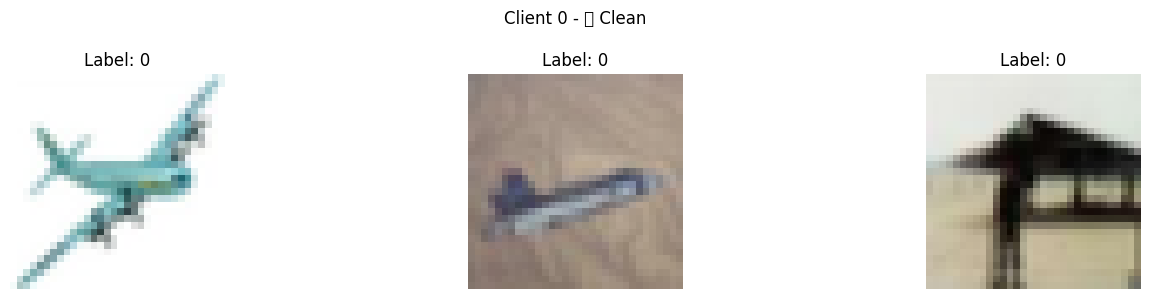

/tmp/ipykernel_1677204/492079149.py:60: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


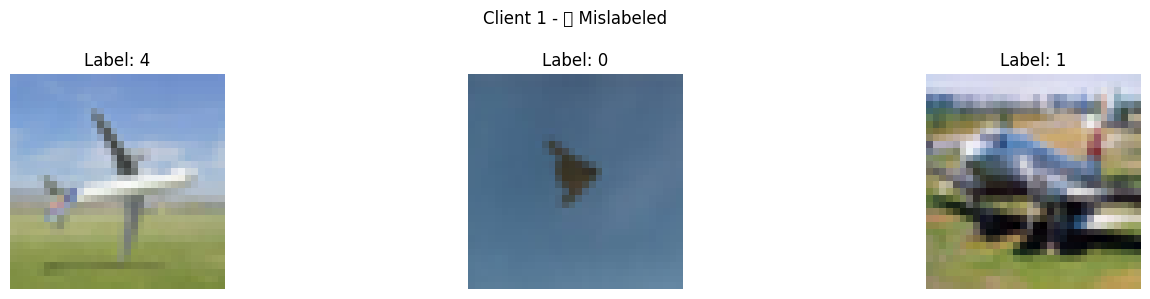

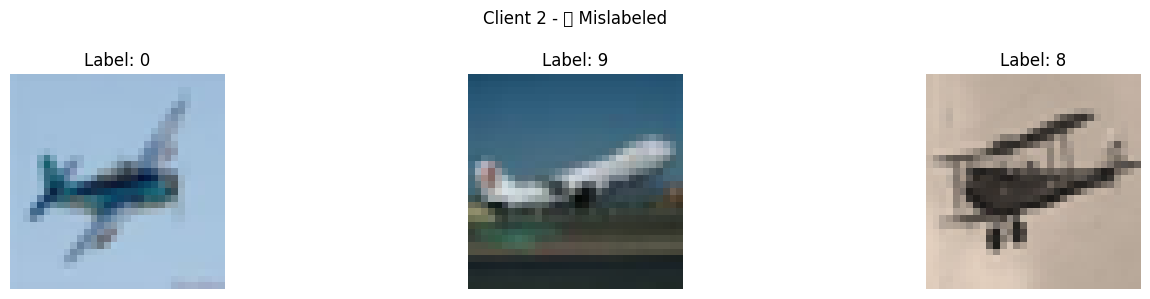

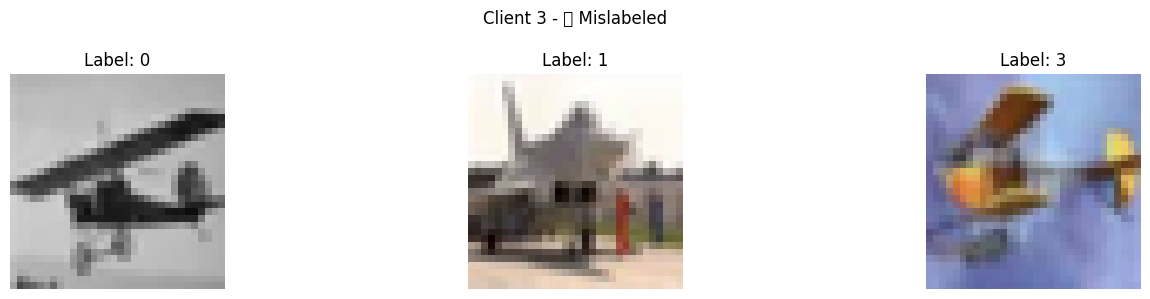

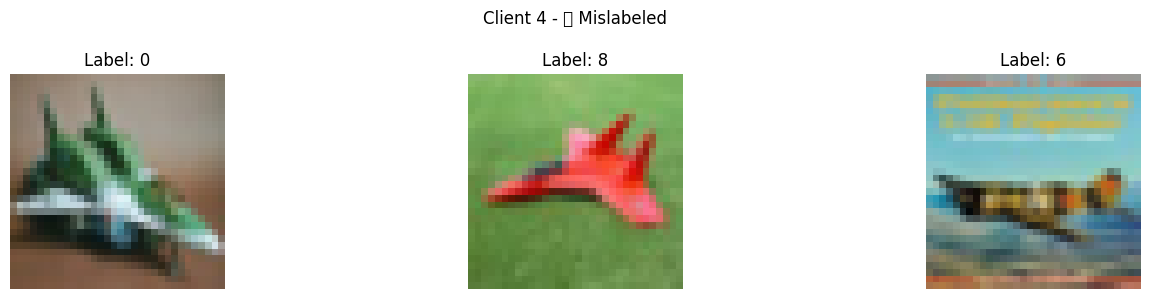

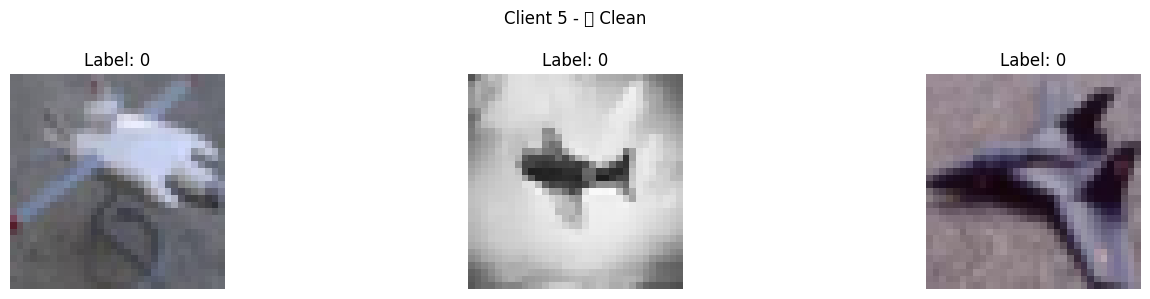

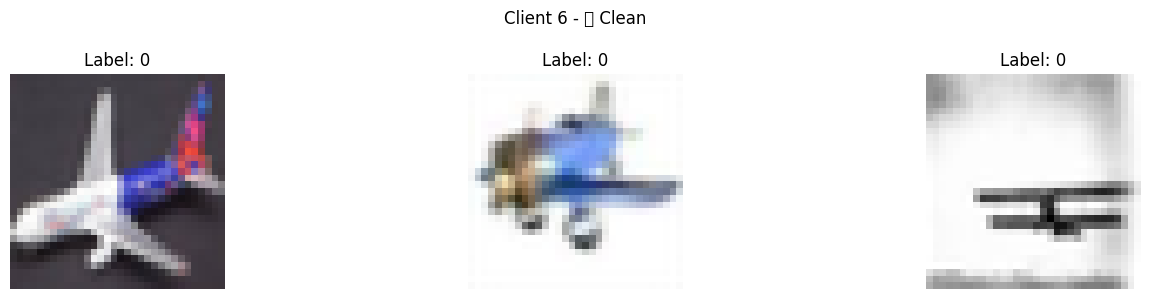

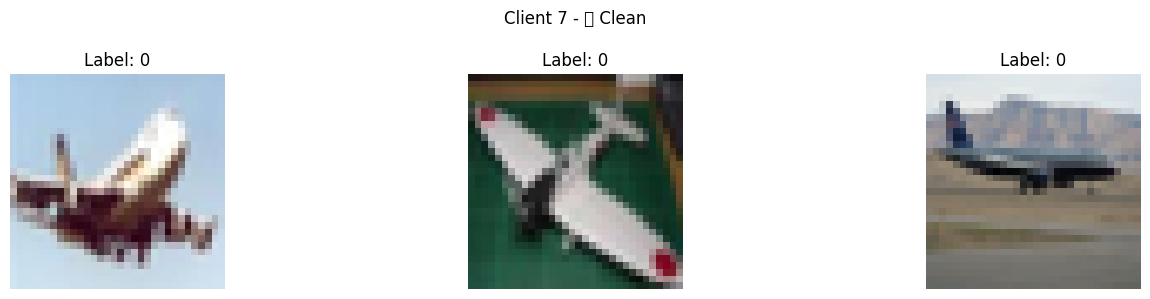

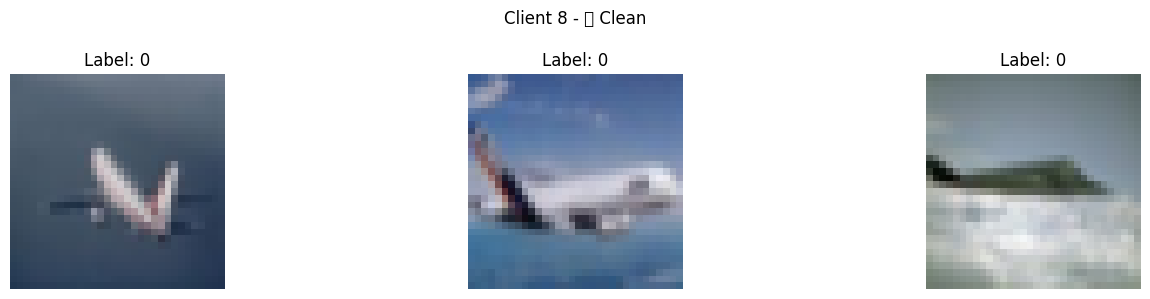

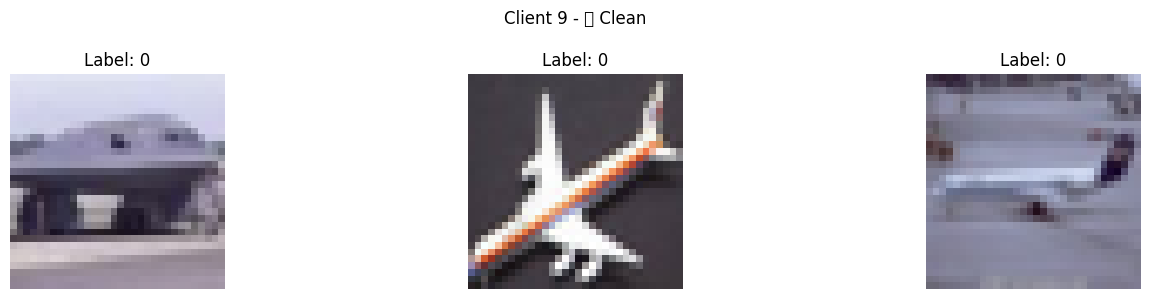

In [11]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import os

def mislabel_partial_data(client_data, mislabel_fraction=0.6, num_classes=10):
    """
    Mislabel a fraction of the client's data.
    Ensures new label is different from the original.
    """
    num_samples = len(client_data)
    num_to_mislabel = int(num_samples * mislabel_fraction)

    indices = list(range(num_samples))
    random.shuffle(indices)
    mislabeled_indices = set(indices[:num_to_mislabel])

    new_client_data = []
    for i, (img_tensor, label) in enumerate(client_data):
        if i in mislabeled_indices:
            possible_labels = list(range(num_classes))
            possible_labels.remove(label)
            new_label = random.choice(possible_labels)
            new_client_data.append((img_tensor, new_label))
        else:
            new_client_data.append((img_tensor, label))
    return new_client_data

def save_mislabeled_clients_data(clients_data, output_path, clients_to_mislabel, mislabel_fraction=0.6, num_classes=10):
    """
    Apply partial mislabeling to specified clients.
    Others remain clean.
    """
    processed_data = []
    for i, client in enumerate(clients_data):
        if i in clients_to_mislabel:
            client_samples = mislabel_partial_data(client, mislabel_fraction, num_classes)
        else:
            client_samples = client
        processed_data.append(client_samples)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    torch.save(processed_data, output_path)

def show_last_images_from_client(pt_file, client_index=0, num_images=3, title=''):
    clients_data = torch.load(pt_file)
    client_data = clients_data[client_index]
    last_samples = client_data[-num_images:]

    plt.figure(figsize=(15, 3))
    for i, (img_tensor, label) in enumerate(last_samples):
        img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
        img_np = np.clip(img_np, 0, 1)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_np)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def main(clients_to_mislabel, mislabel_fraction=0.6, num_classes=10):
    # data_path = 'non_IID/clients_no_10_data_IID_CIFAR10_alpha_0.5.pt'
    data_path = 'IID/clients_no_10_data_IID_CIFAR10_alpha_infinity.pt'
    clients_data = torch.load(data_path)

    mislabeled_save_path = (
        f'mislabelled/IID_clients_{"_".join(map(str, clients_to_mislabel))}_'
        f'{int(mislabel_fraction*100)}pct_mislabeled_CIFAR10_infinity.pt'
    )

    save_mislabeled_clients_data(
        clients_data, mislabeled_save_path, clients_to_mislabel,
        mislabel_fraction=mislabel_fraction, num_classes=num_classes
    )

    print(f"[✓] Saved mislabeled client dataset at: {mislabeled_save_path}")

    for idx in range(len(clients_data)):
        if idx in clients_to_mislabel:
            title = f'Client {idx} - 🔴 Mislabeled'
        else:
            title = f'Client {idx} - 🟢 Clean'
        show_last_images_from_client(mislabeled_save_path, client_index=idx, title=title)


if __name__ == "__main__":
    main([1,2,3,4])


<H1>IID and non_IID dataset distribution</H1>

In [20]:
import torch
import numpy as np
import random
from torchvision import datasets, transforms
from collections import defaultdict, Counter
import os

def split_dataset_dirichlet_fixed_size(dataset, num_clients, alpha):
    """
    Split dataset among `num_clients` using Dirichlet distribution over class labels,
    but ensures each client gets the same number of total samples.
    """
    # Group data by class
    data_by_class = defaultdict(list)
    for idx, (img, label) in enumerate(dataset):
        data_by_class[label].append((img, label))
    
    for k in data_by_class:
        random.shuffle(data_by_class[k])
    
    num_classes = len(data_by_class)
    total_samples = len(dataset)
    samples_per_client = total_samples // num_clients
    
    # Create empty list for each client
    clients_data = [[] for _ in range(num_clients)]
    class_indices = {cls: 0 for cls in data_by_class}
    
    # Compute proportions using Dirichlet
    class_counts = {cls: len(data_by_class[cls]) for cls in data_by_class}
    class_proportions = {cls: np.random.dirichlet([alpha] * num_clients) for cls in data_by_class}

    # Assign data
    client_sample_counts = [0] * num_clients
    client_targets = [samples_per_client] * num_clients

    for cls in range(num_classes):
        cls_data = data_by_class[cls]
        proportions = class_proportions[cls]
        cls_idx = 0

        cls_total = len(cls_data)
        cls_allocations = (proportions * cls_total).astype(int)

        # Adjust to make sure sum == len(cls_data)
        while cls_allocations.sum() < cls_total:
            cls_allocations[np.argmax(proportions)] += 1
        while cls_allocations.sum() > cls_total:
            cls_allocations[np.argmax(cls_allocations)] -= 1

        for client_id, alloc in enumerate(cls_allocations):
            if client_sample_counts[client_id] >= client_targets[client_id]:
                continue  # skip if full

            take = min(alloc, client_targets[client_id] - client_sample_counts[client_id])
            selected_data = cls_data[cls_idx:cls_idx + take]
            clients_data[client_id].extend(selected_data)
            client_sample_counts[client_id] += len(selected_data)
            cls_idx += take

    # Fill underfull clients with random data
    leftovers = []
    for cls_data in data_by_class.values():
        leftovers.extend(cls_data)
    random.shuffle(leftovers)

    for client_id in range(num_clients):
        while client_sample_counts[client_id] < client_targets[client_id] and leftovers:
            clients_data[client_id].append(leftovers.pop())
            client_sample_counts[client_id] += 1

    return clients_data

def print_data_distribution(clients_data):
    for idx, client in enumerate(clients_data):
        labels = [label for (_, label) in client]
        class_counts = Counter(labels)
        sorted_counts = dict(sorted(class_counts.items()))
        print(f"Client {idx} - Total Samples: {len(labels)} - Class Distribution: {sorted_counts}")

def prepare_cifar10_clients(distribution='dirichlet_fixed', alpha=0.5, num_clients=10):
    transform = transforms.ToTensor()
    cifar_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    if distribution == 'dirichlet_fixed':
        clients_data = split_dataset_dirichlet_fixed_size(cifar_train, num_clients, alpha)
    else:
        raise ValueError("Only 'dirichlet_fixed' distribution supported in this version.")

    filename = f"clients_no_{num_clients}_dirichlet_fixed_alpha_{alpha}.pt"
    torch.save(clients_data, filename)
    print(f"[✓] Saved client dataset at: {filename}\n")

    print("[📊] Class Distribution per Client:")
    print_data_distribution(clients_data)

# Example call:
# prepare_cifar10_clients(distribution='dirichlet_fixed', alpha=0.3, num_clients=10)


In [21]:
prepare_cifar10_clients(distribution='dirichlet_fixed', alpha=0.3, num_clients=10)

Files already downloaded and verified
[✓] Saved client dataset at: clients_no_10_dirichlet_fixed_alpha_0.3.pt

[📊] Class Distribution per Client:
Client 0 - Total Samples: 5000 - Class Distribution: {0: 9, 1: 30, 2: 873, 3: 282, 4: 55, 5: 33, 6: 768, 7: 38, 8: 518, 9: 2394}
Client 1 - Total Samples: 5000 - Class Distribution: {0: 439, 1: 916, 2: 399, 3: 329, 4: 333, 5: 387, 6: 790, 7: 640, 8: 445, 9: 322}
Client 2 - Total Samples: 5000 - Class Distribution: {0: 100, 1: 7, 2: 174, 4: 597, 5: 1705, 6: 707, 7: 1710}
Client 3 - Total Samples: 5000 - Class Distribution: {0: 175, 1: 17, 2: 3205, 3: 31, 4: 1151, 6: 421}
Client 4 - Total Samples: 5000 - Class Distribution: {0: 492, 1: 148, 2: 93, 3: 294, 4: 564, 5: 1661, 6: 241, 7: 855, 8: 74, 9: 578}
Client 5 - Total Samples: 5000 - Class Distribution: {0: 345, 1: 306, 2: 360, 3: 362, 4: 349, 5: 313, 6: 453, 7: 347, 8: 1398, 9: 767}
Client 6 - Total Samples: 5000 - Class Distribution: {1: 20, 2: 26, 3: 3237, 4: 726, 5: 15, 6: 976}
Client 7 - 

In [ ]:
# import torch
# import numpy as np
# import random
# from torchvision import datasets, transforms
# from collections import defaultdict, Counter
# import os

# def split_dataset_iid(dataset, num_clients):
#     """
#     Split dataset into `num_clients` IID subsets with equal class and sample count.
#     """
#     data_by_class = defaultdict(list)
#     for idx, (img, label) in enumerate(dataset):
#         data_by_class[label].append((img, label))

#     for label in data_by_class:
#         random.shuffle(data_by_class[label])

#     clients_data = [[] for _ in range(num_clients)]
#     for label, data in data_by_class.items():
#         chunk_size = len(data) // num_clients
#         for i in range(num_clients):
#             clients_data[i].extend(data[i*chunk_size:(i+1)*chunk_size])
#     return clients_data

# def split_dataset_dirichlet(dataset, num_clients, alpha):
#     """
#     Split dataset into `num_clients` using Dirichlet distribution based on alpha.
#     """
#     data_by_class = defaultdict(list)
#     for idx, (img, label) in enumerate(dataset):
#         data_by_class[label].append((img, label))

#     clients_data = [[] for _ in range(num_clients)]

#     for label, items in data_by_class.items():
#         np.random.shuffle(items)
#         proportions = np.random.dirichlet([alpha] * num_clients)
#         proportions = (np.cumsum(proportions) * len(items)).astype(int)[:-1]
#         splits = np.split(items, proportions)
#         for i, split in enumerate(splits):
#             clients_data[i].extend(split.tolist())

#     return clients_data

# def print_data_distribution(clients_data):
#     """
#     Print the distribution of class labels for each client.
#     """
#     for idx, client in enumerate(clients_data):
#         labels = [label for (_, label) in client]
#         class_counts = Counter(labels)
#         sorted_counts = dict(sorted(class_counts.items()))
#         print(f"Client {idx} - Total Samples: {len(labels)} - Class Distribution: {sorted_counts}")

# def prepare_cifar10_clients(distribution='IID', alpha='infinity', num_clients=6):
#     """
#     Main function to prepare CIFAR-10 clients based on input parameters.
#     """
#     transform = transforms.ToTensor()
#     cifar_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

#     if distribution == 'IID' and alpha == 'infinity':
#         clients_data = split_dataset_iid(cifar_train, num_clients)
#     elif distribution == 'IID':
#         try:
#             alpha_value = float(alpha)
#             clients_data = split_dataset_dirichlet(cifar_train, num_clients, alpha_value)
#         except ValueError:
#             raise ValueError("Invalid alpha value. Use 'infinity' or a float.")
#     else:
#         raise ValueError("Only 'IID' distribution is supported in this version.")

#     filename = f"clients_no_{num_clients}_data_{distribution}_CIFAR10_alpha_{alpha}.pt"
#     torch.save(clients_data, filename)
#     print(f"[✓] Saved client dataset at: {filename}")

#     # Print class distribution
#     print("\n[📊] Class Distribution per Client:")
#     print_data_distribution(clients_data)

# # Example call:
# # prepare_cifar10_clients('IID', 'infinity', 6)
# # prepare_cifar10_clients('IID', 0.1, 6)


In [11]:
# prepare_cifar10_clients('IID', 'infinity', 5)  # True IID

In [ ]:
# prepare_cifar10_clients('IID', 0.1, 5)         # Dirichlet non-IID with alpha=0.1

<H1>Add salt and Pepper to dataset distribution</H1>

[✓] Saved noisy client dataset at: salt_pepper/clients_no_4_10_non_IID_0.5_CIFAR10_alpha_infinity_0.6.pt


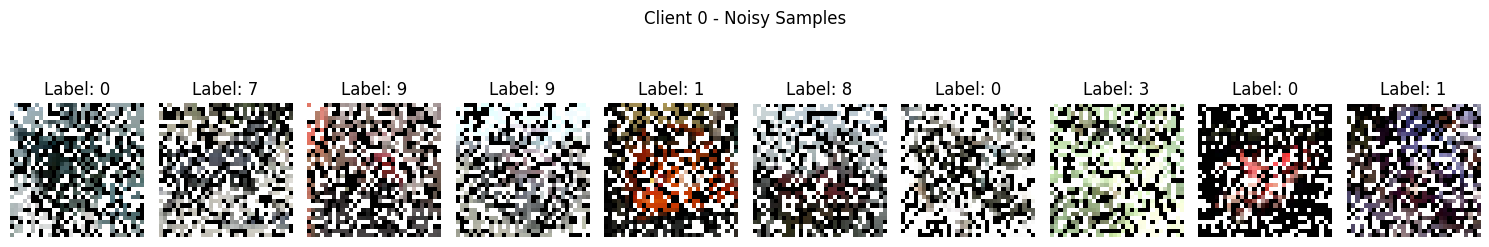

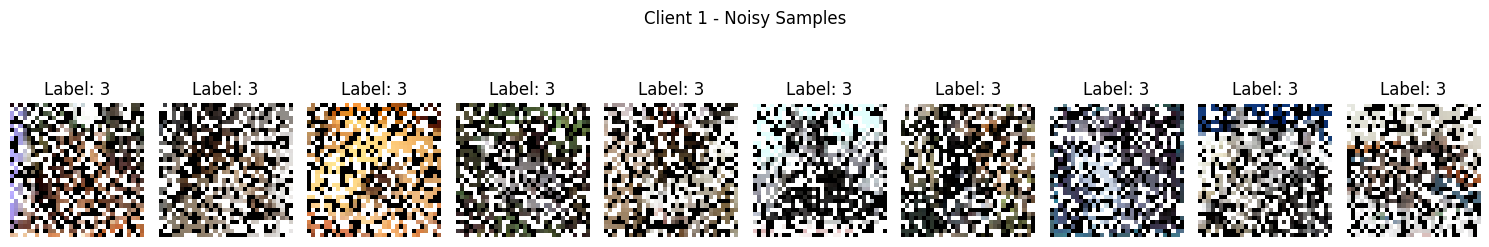

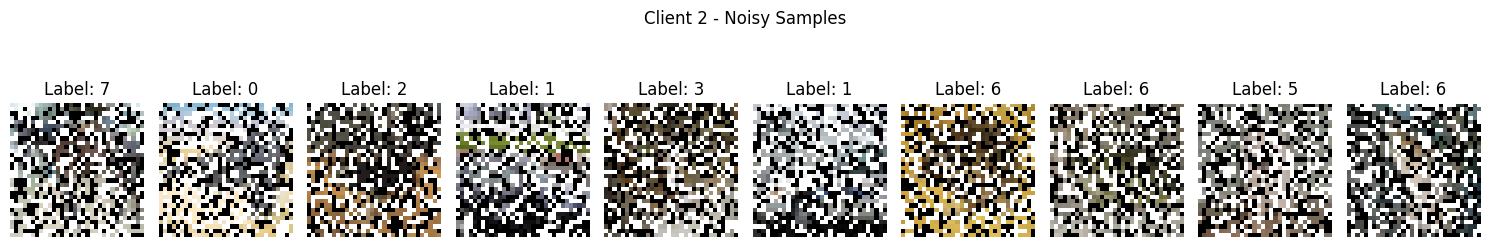

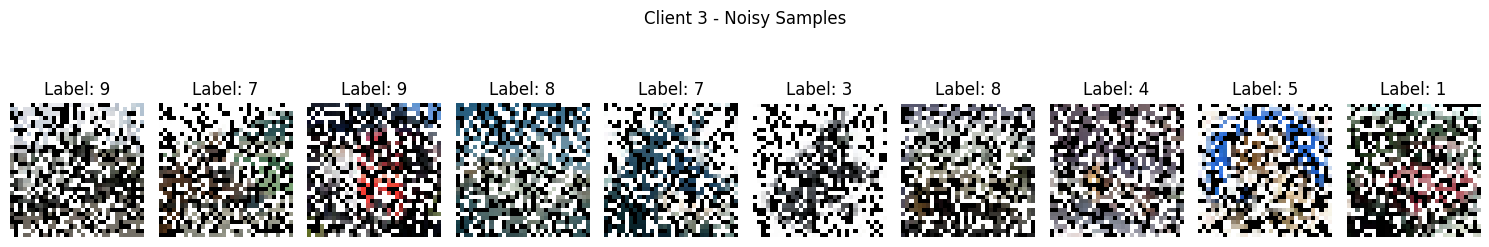

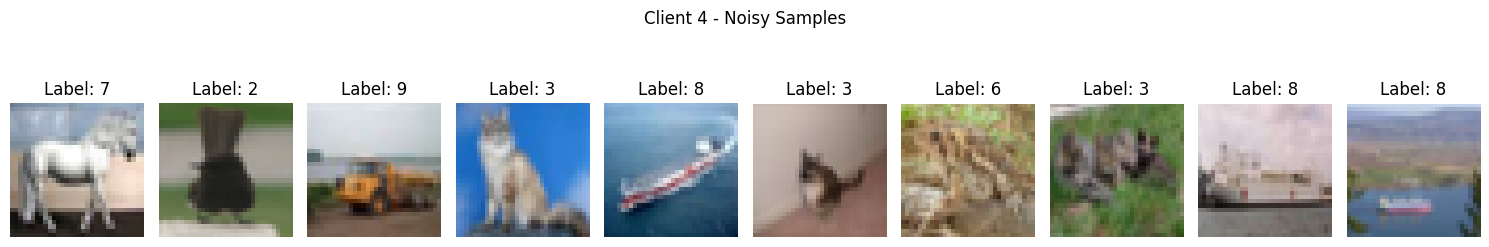

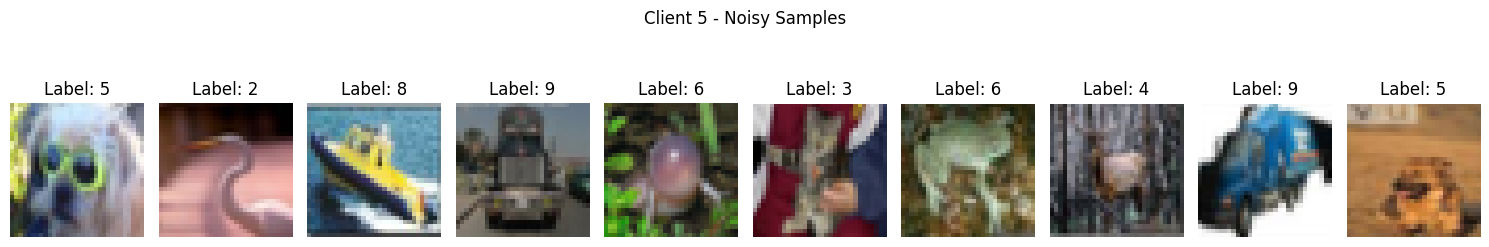

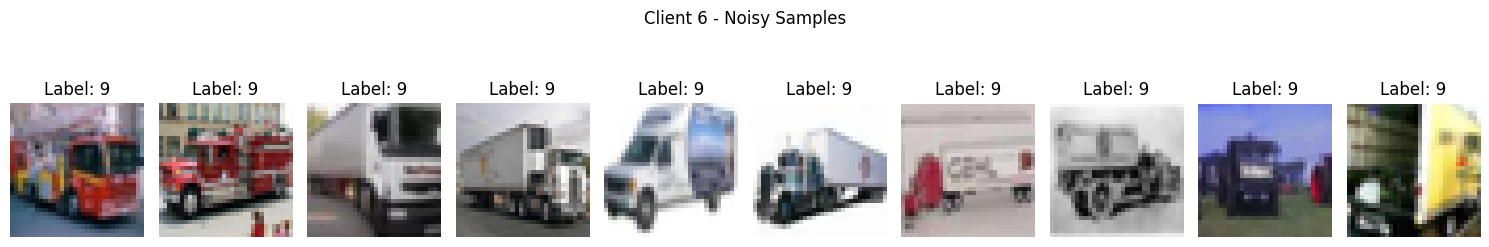

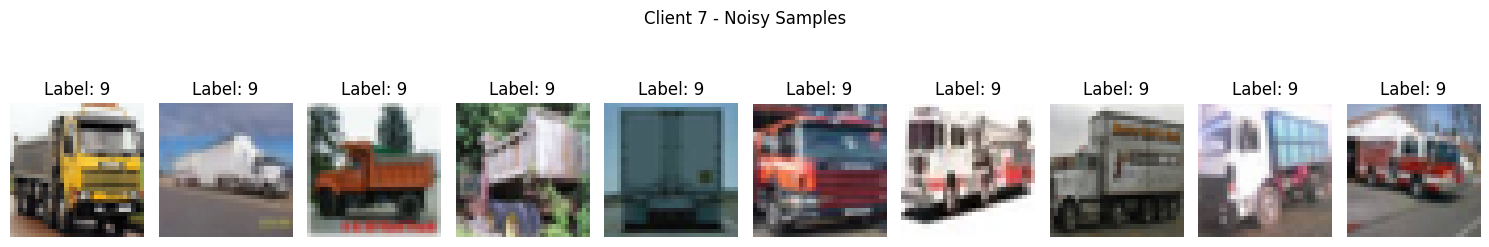

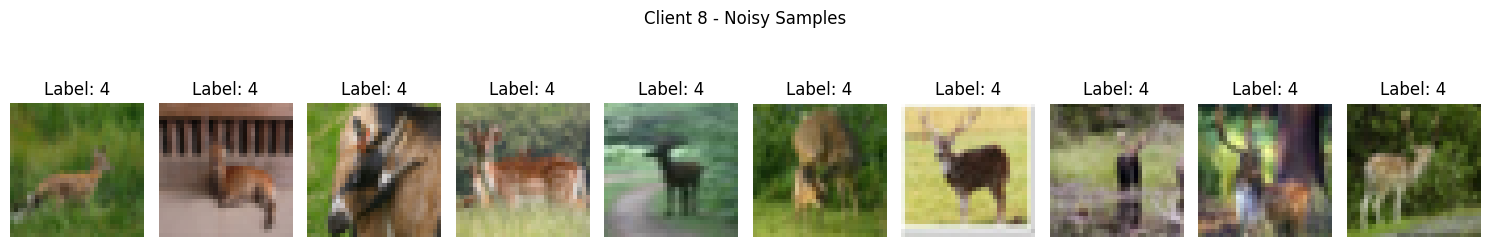

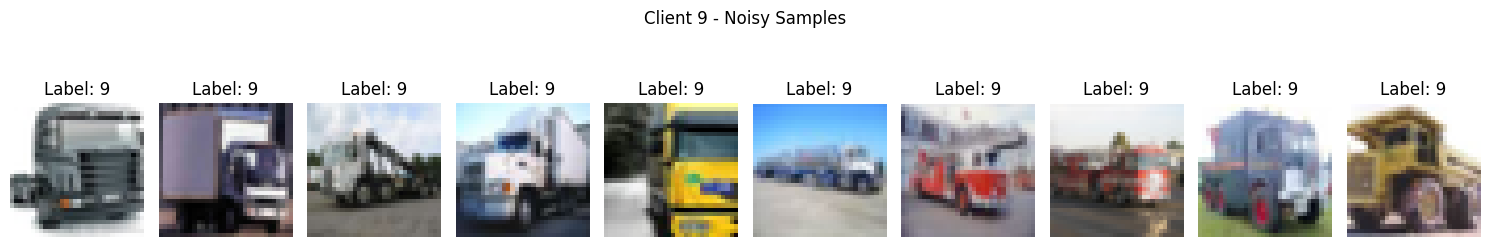

In [8]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import os

def add_salt_pepper_noise(img_tensor, salt_prob, pepper_prob):
    img = img_tensor.clone().clamp(0.0, 1.0)

    c, h, w = img.shape
    total_pixels = h * w

    num_salt = int(total_pixels * salt_prob)
    num_pepper = int(total_pixels * pepper_prob)

    all_indices = np.arange(total_pixels)
    np.random.shuffle(all_indices)

    salt_indices = all_indices[:num_salt]
    pepper_indices = all_indices[num_salt:num_salt + num_pepper]

    salt_coords = np.unravel_index(salt_indices, (h, w))
    pepper_coords = np.unravel_index(pepper_indices, (h, w))

    img[:, salt_coords[0], salt_coords[1]] = 1.0
    img[:, pepper_coords[0], pepper_coords[1]] = 0.0

    return img

def save_noisy_clients_data(clients_data, output_path, num_clients_to_noisify, salt_prob=0.4, pepper_prob=0.4):
    """
    Add the SAME salt and pepper noise (salt_prob, pepper_prob) to the first 
    `num_clients_to_noisify` clients. Others remain clean.
    """
    processed_data = []
    for i, client in enumerate(clients_data):
        client_samples = []
        if i < num_clients_to_noisify:
            for img_tensor, label in client:
                noisy_img = add_salt_pepper_noise(img_tensor, salt_prob, pepper_prob)
                client_samples.append((noisy_img, label))
        else:
            # No noise added
            client_samples = client
        processed_data.append(client_samples)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    torch.save(processed_data, output_path)

def show_last_images_from_client(pt_file, client_index=0, num_images=10, title=''):
    clients_data = torch.load(pt_file)
    client_data = clients_data[client_index]
    last_samples = client_data[-num_images:]

    plt.figure(figsize=(15, 3))
    for i, (img_tensor, label) in enumerate(last_samples):
        img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
        img_np = np.clip(img_np, 0, 1)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_np)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def main(num_clients_to_noisify=3, salt_prob=0.3, pepper_prob=0.3):
    data_path = 'non_IID/clients_no_10_data_IID_CIFAR10_alpha_0.5.pt'
    # data_path = 'IID/clients_no_10_data_IID_CIFAR10_alpha_infinity.pt'
    clients_data = torch.load(data_path)
    noisy_save_path = f'salt_pepper/clients_no_{num_clients_to_noisify}_10_non_IID_0.5_CIFAR10_alpha_infinity_{salt_prob+salt_prob}.pt'
    # noisy_save_path = f'salt_pepper/clients_no_{num_clients_to_noisify}_10_IID_CIFAR10_alpha_infinity_{salt_prob+salt_prob}.pt'
    save_noisy_clients_data(clients_data, noisy_save_path, num_clients_to_noisify, salt_prob, pepper_prob)
    print(f"[✓] Saved noisy client dataset at: {noisy_save_path}")

    for idx in range(len(clients_data)):
        show_last_images_from_client(noisy_save_path, client_index=idx, title=f'Client {idx} - Noisy Samples')

if __name__ == "__main__":
    noisy_clients=4
    main(num_clients_to_noisify=noisy_clients, salt_prob=0.3, pepper_prob=0.3)


In [ ]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import os

def add_salt_pepper_noise(img_tensor, salt_prob, pepper_prob):
    img = img_tensor.clone().clamp(0.0, 1.0)

    c, h, w = img.shape
    total_pixels = h * w

    num_salt = int(total_pixels * salt_prob)
    num_pepper = int(total_pixels * pepper_prob)

    all_indices = np.arange(total_pixels)
    np.random.shuffle(all_indices)

    salt_indices = all_indices[:num_salt]
    pepper_indices = all_indices[num_salt:num_salt + num_pepper]

    salt_coords = np.unravel_index(salt_indices, (h, w))
    pepper_coords = np.unravel_index(pepper_indices, (h, w))

    img[:, salt_coords[0], salt_coords[1]] = 1.0
    img[:, pepper_coords[0], pepper_coords[1]] = 0.0

    return img

def save_noisy_clients_data(clients_data, output_path, client_noise_levels):
    """
    Add salt and pepper noise per client based on client_noise_levels list:
    client_noise_levels = [(salt_prob1, pepper_prob1), (salt_prob2, pepper_prob2), ...]
    If no noise level given for a client, no noise added.
    """
    processed_data = []
    for i, client in enumerate(clients_data):
        salt_prob, pepper_prob = (0.0, 0.0)  # default no noise
        if i < len(client_noise_levels):
            salt_prob, pepper_prob = client_noise_levels[i]

        client_samples = []
        for img_tensor, label in client:
            if salt_prob > 0 or pepper_prob > 0:
                noisy_img = add_salt_pepper_noise(img_tensor, salt_prob, pepper_prob)
                client_samples.append((noisy_img, label))
            else:
                client_samples.append((img_tensor, label))

        processed_data.append(client_samples)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    torch.save(processed_data, output_path)

def show_last_images_from_client(pt_file, client_index=0, num_images=10, title=''):
    clients_data = torch.load(pt_file)
    client_data = clients_data[client_index]
    last_samples = client_data[-num_images:]

    plt.figure(figsize=(15, 3))
    for i, (img_tensor, label) in enumerate(last_samples):
        img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
        img_np = np.clip(img_np, 0, 1)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_np)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def main(client_noise_levels):
    data_path = 'non_IID/clients_no_10_data_IID_CIFAR10_alpha_0.1.pt'
    clients_data = torch.load(data_path)

    noisy_save_path = f'salt_pepper/clients_data_cifar10_4_6_varied_noise.pt'
    save_noisy_clients_data(clients_data, noisy_save_path, client_noise_levels)
    print(f"[✓] Saved noisy client dataset at: {noisy_save_path}")

    for idx in range(len(clients_data)):
        show_last_images_from_client(noisy_save_path, client_index=idx, title=f'Client {idx} - Noisy Samples')

if __name__ == "__main__":
    # Define salt and pepper noise levels per client
    # Example: first 4 clients get increasing noise, others no noise
    client_noise_levels = [
        (0.1, 0.1),  # client 0
        (0.25, 0.25),# client 1
        (0.4, 0.4),  # client 2
        (0.5, 0.5),  # client 3
        # clients 4 and 5 get no noise because not specified
    ]
    main(client_noise_levels)


In [ ]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import os

def add_salt_pepper_noise(img_tensor, salt_prob, pepper_prob):
    img = img_tensor.clone().clamp(0.0, 1.0)

    c, h, w = img.shape
    total_pixels = h * w

    num_salt = int(total_pixels * salt_prob)
    num_pepper = int(total_pixels * pepper_prob)

    all_indices = np.arange(total_pixels)
    np.random.shuffle(all_indices)

    salt_indices = all_indices[:num_salt]
    pepper_indices = all_indices[num_salt:num_salt + num_pepper]

    salt_coords = np.unravel_index(salt_indices, (h, w))
    pepper_coords = np.unravel_index(pepper_indices, (h, w))

    img[:, salt_coords[0], salt_coords[1]] = 1.0
    img[:, pepper_coords[0], pepper_coords[1]] = 0.0

    return img

def save_noisy_clients_data(clients_data, output_path, client_noise_levels):
    """
    Add salt and pepper noise per client based on client_noise_levels list:
    client_noise_levels = [(salt_prob1, pepper_prob1), (salt_prob2, pepper_prob2), ...]
    If no noise level given for a client, no noise added.
    """
    processed_data = []
    for i, client in enumerate(clients_data):
        salt_prob, pepper_prob = (0.0, 0.0)  # default no noise
        if i < len(client_noise_levels):
            salt_prob, pepper_prob = client_noise_levels[i]

        client_samples = []
        for img_tensor, label in client:
            if salt_prob > 0 or pepper_prob > 0:
                noisy_img = add_salt_pepper_noise(img_tensor, salt_prob, pepper_prob)
                client_samples.append((noisy_img, label))
            else:
                client_samples.append((img_tensor, label))

        processed_data.append(client_samples)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    torch.save(processed_data, output_path)

def show_last_images_from_client(pt_file, client_index=0, num_images=10, title=''):
    clients_data = torch.load(pt_file)
    client_data = clients_data[client_index]
    last_samples = client_data[-num_images:]

    plt.figure(figsize=(15, 3))
    for i, (img_tensor, label) in enumerate(last_samples):
        img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
        img_np = np.clip(img_np, 0, 1)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_np)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def main(client_noise_levels):
    data_path = 'IID/clients_no_20_data_IID_CIFAR10_alpha_infinity.pt'
    clients_data = torch.load(data_path)

    noisy_save_path = f'salt_pepper/clients_data_cifar10_10_20_varied_noise.pt'
    save_noisy_clients_data(clients_data, noisy_save_path, client_noise_levels)
    print(f"[✓] Saved noisy client dataset at: {noisy_save_path}")

    for idx in range(len(clients_data)):
        show_last_images_from_client(noisy_save_path, client_index=idx, title=f'Client {idx} - Noisy Samples')

if __name__ == "__main__":
    # Define salt and pepper noise levels per client
    # Example: first 4 clients get increasing noise, others no noise
    client_noise_levels = [
        (0.1, 0.1),  # client 0
        (0.15, 0.15),# client 1
        (0.2, 0.2),  # client 2
        (0.25, 0.25),  # client 3
        (0.3, 0.3),  # client 4
        (0.35, 0.35),  # client 5
        (0.4, 0.4),  # client 6
        (0.5, 0.5),  # client 7
        (0.27, 0.27),  # client 8
        (0.18, 0.18),  # client 9
        # clients 4 and 5 get no noise because not specified
    ]
    main(client_noise_levels)
